In [1]:
import os, shutil
# 1. Find nvcc and set CUDA_HOME dynamically if it’s not already set
nvcc_path = shutil.which("nvcc")
if nvcc_path:
    cuda_root = os.path.dirname(os.path.dirname(nvcc_path))
    os.environ["CUDA_HOME"] = cuda_root
    print("CUDA_HOME set to:", cuda_root)
else:
    print("nvcc not found on PATH—CUDA_HOME remains unset")

# 2. Point XLA at the libdevice folder (only needed if you got libdevice errors)
os.environ["XLA_FLAGS"] = f"--xla_gpu_cuda_data_dir={os.environ.get('CUDA_HOME','')}"

# 3. Verify ptxas is available
ptxas = shutil.which("ptxas")
print("ptxas at:", ptxas if ptxas else "not found")

# 4. Now import TF and list devices
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all logs, 1=filter INFO, 2=filter WARNING, 3=filter ERROR
import tensorflow as tf
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Physical GPUs:", tf.config.list_physical_devices("GPU"))

# 5. Run a tiny GPU workload with placement logging
tf.debugging.set_log_device_placement(False)
with tf.device("/GPU:0"):
    a = tf.random.uniform((256,256))
    b = tf.random.uniform((256,256))
    c = tf.matmul(a, b)
print("Result is on:", c.device)


CUDA_HOME set to: /home/mcw77/.conda/envs/test_env
ptxas at: /home/mcw77/.conda/envs/test_env/bin/ptxas


2025-05-16 13:55:57.065174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 13:55:57.065208: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 13:55:57.065215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Built with CUDA: True
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
Result is on: /job:localhost/replica:0/task:0/device:GPU:0


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import tensorflow_addons as tfa
plt.style.use('ggplot')

#possible angles: 20, 40, 60, 80, 100, 120, 140
#output vector is 7d: 
#index = (angle/02) - 1
#angle = (index + 1) * 20


/home/mcw77/.conda/envs/test_env/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
a = np.zeros(7)
angle = 60
a[int(angle/20 - 1)] = 1
a

array([0., 0., 1., 0., 0., 0., 0.])

In [4]:
# 1) Parameters
IMG_SIZE = (512, 512)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
file_dir = 'VarBrAngle_StdDev/'
all_files = tf.io.gfile.listdir(file_dir)
#only want tif
all_files = [f for f in all_files if f[-3:] == 'tif']

In [8]:
def parse_angle_tf(fname):
    parts     = tf.strings.split(fname, 'BrAngle-')
    angle_str = tf.strings.split(parts[-1], '.')[0]
    angle     = tf.strings.to_number(angle_str, tf.int32)
    idx       = angle // 20 - 1
    return tf.one_hot(idx, depth=7, dtype=tf.float32)  # shape=(7,)
    
def _load_tiff_with_pil(path_bytes):
    # path_bytes is a bytes tensor → numpy bytes
    path = path_bytes.numpy().decode()
    full = os.path.join(file_dir, path)
    with Image.open(full) as img:
        # don't convert to "L" (8-bit) — keep full bit depth
        img = img.resize(IMG_SIZE, Image.BILINEAR)
        arr = np.array(img, dtype=np.float32) / 65535.0 + np.random.normal(0, 0.05, size = IMG_SIZE)
    # add channel dim
    return arr.reshape((*IMG_SIZE, 1))

def load_and_preprocess(fname):
    img = tf.py_function(
        func=_load_tiff_with_pil,
        inp=[fname],
        Tout=tf.float32)
    img.set_shape([*IMG_SIZE, 1])
    label = parse_angle_tf(fname)
    return img, label

# 4. a small augmentation pipeline
def augment(image, label):
    return image, label


    '''
    # random left/right flip
    image = tf.image.random_flip_left_right(image)
    # random up/down flip
    image = tf.image.random_flip_up_down(image)
    # small random rotation (multiples of 90°)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    # random brightness + contrast
    #image = tf.image.random_brightness(image, max_delta=0.1)
    #image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
     # ensure values are in [0,1], then round to 0 or 1
    #image = tf.clip_by_value(image, 0.0, 1.0)
    #image = tf.round(image)  # values → {0., 1.}
    return image, label
    '''

In [9]:
# split your filenames once
batch_size = 10

n = len(all_files)
train_filenames = all_files[: int(0.8*n)]
val_filenames   = all_files[int(0.8*n):]


# 5. build your datasets
train_ds = (tf.data.Dataset
    .from_tensor_slices(train_filenames)
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment,               num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1024)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (tf.data.Dataset
    .from_tensor_slices(val_filenames)
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
# pick one filename
sample = train_filenames[7]
print(sample)
# 1) load + preprocess
img, lbl = load_and_preprocess(sample)
print("After load/preprocess:", img.shape, img.dtype,
      "min/max =", tf.reduce_min(img).numpy(), tf.reduce_max(img).numpy(),
      "label =", lbl.numpy())

# 2) augment
aug_img, aug_lbl = augment(img, lbl)
print("After augment:    ", aug_img.shape, aug_img.dtype,
      "min/max =", tf.reduce_min(aug_img).numpy(), tf.reduce_max(aug_img).numpy(),
      "label =", aug_lbl.numpy())

Skeleton-Sample-396-BrAngle-100.00.tif
After load/preprocess: (512, 512, 1) <dtype: 'float32'> min/max = -0.21406996 1.1809555 label = [0. 0. 0. 0. 1. 0. 0.]
After augment:     (512, 512, 1) <dtype: 'float32'> min/max = -0.21406996 1.1809555 label = [0. 0. 0. 0. 1. 0. 0.]


In [11]:
train_ds.cardinality().numpy()

262

In [12]:
he = tf.keras.initializers.HeNormal(seed = 1234321)
l2 = tf.keras.regularizers.l2(1e-4)

def build_conv_model():
    return tf.keras.Sequential([
        # input: 512×512 grayscale
        tf.keras.layers.Input((512, 512, 1)),

        # Stem: 512→128 via a big strided conv
        tf.keras.layers.Conv2D(
            32, kernel_size=7, strides=4, padding='same',
            activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.SpatialDropout2D(0.1),

        # Block 1: 128→64
        tf.keras.layers.Conv2D(
            64, kernel_size=3, strides=2, padding='same',
            activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.SpatialDropout2D(0.1),

        # Block 2:  64→32
        tf.keras.layers.Conv2D(
            128, kernel_size=3, strides=2, padding='same',
            activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.SpatialDropout2D(0.1),

        # Block 3:  32→16
        tf.keras.layers.Conv2D(
            256, kernel_size=3, strides=2, padding='same',
            activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.SpatialDropout2D(0.1),

        # Global pool + dense head
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(
            128, activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(
            64, activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(
            32, activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.Dropout(0.3),

        # Final 7-way output
        tf.keras.layers.Dense(
            7, activation='softmax',
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
    ])

In [13]:
model = build_conv_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      1600      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 spatial_dropout2d (Spatial  (None, 128, 128, 32)      0         
 Dropout2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        2

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


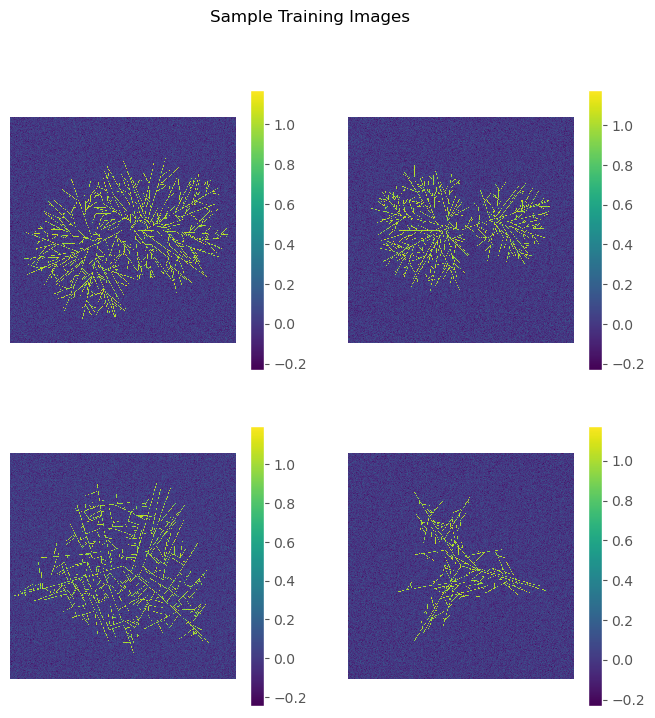

In [14]:
plt.figure(figsize=(8,8))
for i, (img, lbl) in enumerate(train_ds.unbatch().take(4)):
    plt.subplot(2,2,i+1)
    print(img.shape)
    plt.imshow(img.numpy().squeeze(), interpolation='nearest')
    plt.colorbar()
    plt.axis('off')

plt.suptitle("Sample Training Images")
plt.show()

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

Epoch 1/50


2025-05-16 13:56:39.200485: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


262/262 [==============================] - 36s 81ms/step - loss: 1.9200 - accuracy: 0.2854 - val_loss: 1.4334 - val_accuracy: 0.5214
Epoch 2/50
262/262 [==============================] - 30s 80ms/step - loss: 1.7093 - accuracy: 0.3401 - val_loss: 1.3035 - val_accuracy: 0.5810
Epoch 3/50
262/262 [==============================] - 30s 80ms/step - loss: 1.6334 - accuracy: 0.3761 - val_loss: 1.3119 - val_accuracy: 0.6009
Epoch 4/50
262/262 [==============================] - 30s 80ms/step - loss: 1.5620 - accuracy: 0.4135 - val_loss: 1.2369 - val_accuracy: 0.6376
Epoch 5/50
262/262 [==============================] - 30s 80ms/step - loss: 1.5276 - accuracy: 0.4204 - val_loss: 1.2060 - val_accuracy: 0.6590
Epoch 6/50
262/262 [==============================] - 30s 80ms/step - loss: 1.4646 - accuracy: 0.4438 - val_loss: 1.1395 - val_accuracy: 0.6682
Epoch 7/50
262/262 [==============================] - 30s 80ms/step - loss: 1.4436 - accuracy: 0.4549 - val_loss: 1.1658 - val_accuracy: 0.6223
Epo

KeyboardInterrupt: 

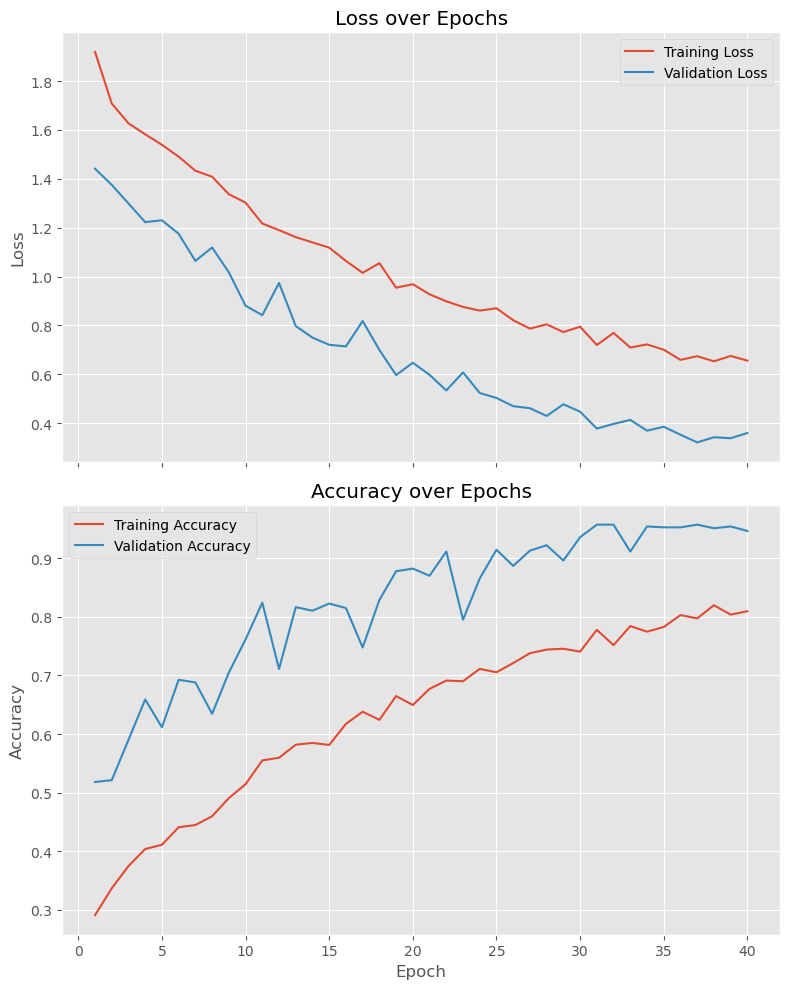

In [45]:
loss       = history.history['loss']
val_loss   = history.history.get('val_loss')
acc        = history.history.get('accuracy')
val_acc    = history.history.get('val_accuracy')

epochs = range(1, len(loss) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# --- Plot Loss on top panel ---
ax1.plot(epochs, loss,   label='Training Loss')
if val_loss is not None:
    ax1.plot(epochs, val_loss, label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Epochs')
ax1.legend()
ax1.grid(True)

if acc is not None:
    ax2.plot(epochs, acc,   label='Training Accuracy')
    if val_acc is not None:
        ax2.plot(epochs, val_acc, label='Validation Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Accuracy over Epochs')
    ax2.legend()
    ax2.grid(True)
else:
    ax2.text(0.5, 0.5, 'No accuracy data found in history', 
             ha='center', va='center', transform=ax2.transAxes)

plt.tight_layout()
plt.show()
plt.show()

In [46]:
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)

66/66 [==============================] - 2s 23ms/step


In [47]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, cmap=plt.cm.Blues):
    """
    y_true: array of shape (N, C) one-hot encoded
    y_pred: array of shape (N, C) of predicted probabilities or scores
    class_names: list of length C of class labels (optional)
    normalize: if True, normalize each row to sum to 1
    """

    # 1. Convert one‐hot / probabilistic outputs into integer labels
    true_labels = np.argmax(y_true, axis=1)
    pred_labels = np.argmax(y_pred, axis=1)
    n_classes = y_true.shape[1]

    # 2. Compute confusion matrix
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(true_labels, pred_labels):
        cm[t, p] += 1

    # 3. (Optional) Normalize each row
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # 4. Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # 5. Ticks and labels
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label',
           xlabel='Predicted label',
           title='Confusion Matrix')

    # Rotate the tick labels and align
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # 6. Annotate counts or rates
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    ax.invert_yaxis()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

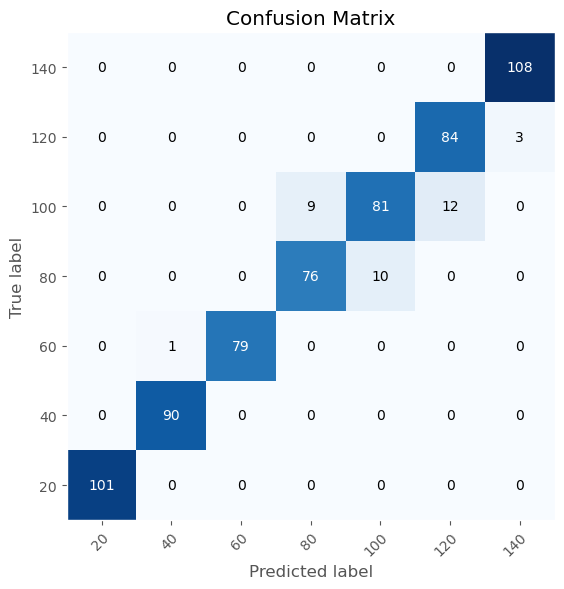

In [48]:
plot_confusion_matrix(y_true, y_pred, class_names = ["20", "40", "60", "80", "100", "120", "140"])